### Data Wrangling 

In [1]:
# Imports
import glob
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
import random

import kagglehub

import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

import shutil

import pandas as pd
from collections import Counter

2025-01-25 07:18:54.505536: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Data Download

In [2]:
# Download latest version
path = kagglehub.dataset_download("paultimothymooney/breast-histopathology-images")

print("Path to dataset files:", path)

Path to dataset files: /home/vscode/.cache/kagglehub/datasets/paultimothymooney/breast-histopathology-images/versions/1


### 2. Data re-structuring

Right now, the data exists in a set of numbered directories, one for each patient. In each patient directory there are two sub-directories `0` and `1` containing IDC negative and IDC positive images. We need to collect all of the IDC negative images and IDC positive images into their own directories.

In [3]:
# Get a list of patient directories
patients=glob.glob(f'{path}/*')

# Set up target directories for file copy
idc_negative_directory='../data/idc_negative/'
idc_positive_directory='../data/idc_positive/'

Path(idc_negative_directory).mkdir(parents=True, exist_ok=True)
Path(idc_positive_directory).mkdir(parents=True, exist_ok=True)

# Loop on the patient directories and copy the '0' images to
# the idc_negative directory and the '1' images to the
# idc_positive directory
for patient in patients:

    # Copy the idc negative images from this patient
    idc_negative_images=glob.glob(f'{patient}/0/*.png')

    for image in idc_negative_images:
        shutil.copy(image, idc_negative_directory)

    # Copy the idc positive images from this patient
    idc_positive_images=glob.glob(f'{patient}/1/*.png')

    for image in idc_positive_images:
        shutil.copy(image, idc_positive_directory)

In [5]:
# Step 1b: Data Sampling for Efficiency
sampled_negative_directory = '../data_sampled/idc_negative/'
sampled_positive_directory = '../data_sampled/idc_positive/'

# Create directories for sampled data
Path(sampled_negative_directory).mkdir(parents=True, exist_ok=True)
Path(sampled_positive_directory).mkdir(parents=True, exist_ok=True)

# Sampling parameters
sample_size = 1000  # Adjust as needed

In [6]:
# Function to sample and copy images
def sample_images(source_dir, target_dir, sample_size):
    images = glob.glob(f'{source_dir}/*.png')
    sampled_images = random.sample(images, min(sample_size, len(images)))
    for image in sampled_images:
        shutil.copy(image, target_dir)

In [7]:
# Sample negative and positive images
sample_images(idc_negative_directory, sampled_negative_directory, sample_size)
sample_images(idc_positive_directory, sampled_positive_directory, sample_size)

print("Sampling complete!")

Sampling complete!


### EDA

In [8]:
idc_negative_count = len(glob.glob(f'{idc_negative_directory}/*.png'))
idc_positive_count = len(glob.glob(f'{idc_positive_directory}/*.png'))

print(f"IDC Negative Images: {idc_negative_count}")
print(f"IDC Positive Images: {idc_positive_count}")

IDC Negative Images: 198738
IDC Positive Images: 78786


In [12]:
def plot_image_samples(positive_images, negative_images, rows=3, cols=2, figsize=(6, 6)):

    # Create the subplot grid
    fig, axs = plt.subplots(rows, cols, figsize=figsize)

    # Zip positive and negative images with the subplot axes
    for pos, neg, row in zip(positive_images[:rows], negative_images[:rows], axs):
        for pic, ax in zip([pos, neg], row):
            img = load_img(pic)  # Load the image
            img_array = img_to_array(img)  # Convert to an array
            img_array /= 255.0  # Normalize the image
            ax.imshow(img_array)  # Display the image
            ax.axis('off')  # Remove axis for better visualization

    plt.suptitle("IDC Negative (Left) vs. Positive (Right)")
    plt.tight_layout()

    plt.show()

In [10]:
# Visualize IDC Negative and Positive Images Side-by-Side
negative_images = glob.glob(f'{idc_negative_directory}/*.png')
positive_images = glob.glob(f'{idc_positive_directory}/*.png')

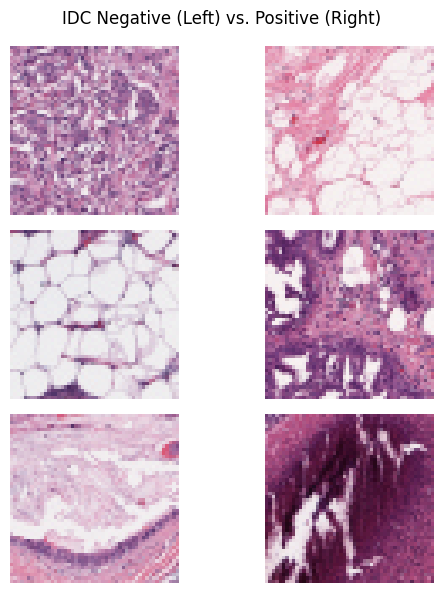

In [13]:
plot_image_samples(positive_images, negative_images)

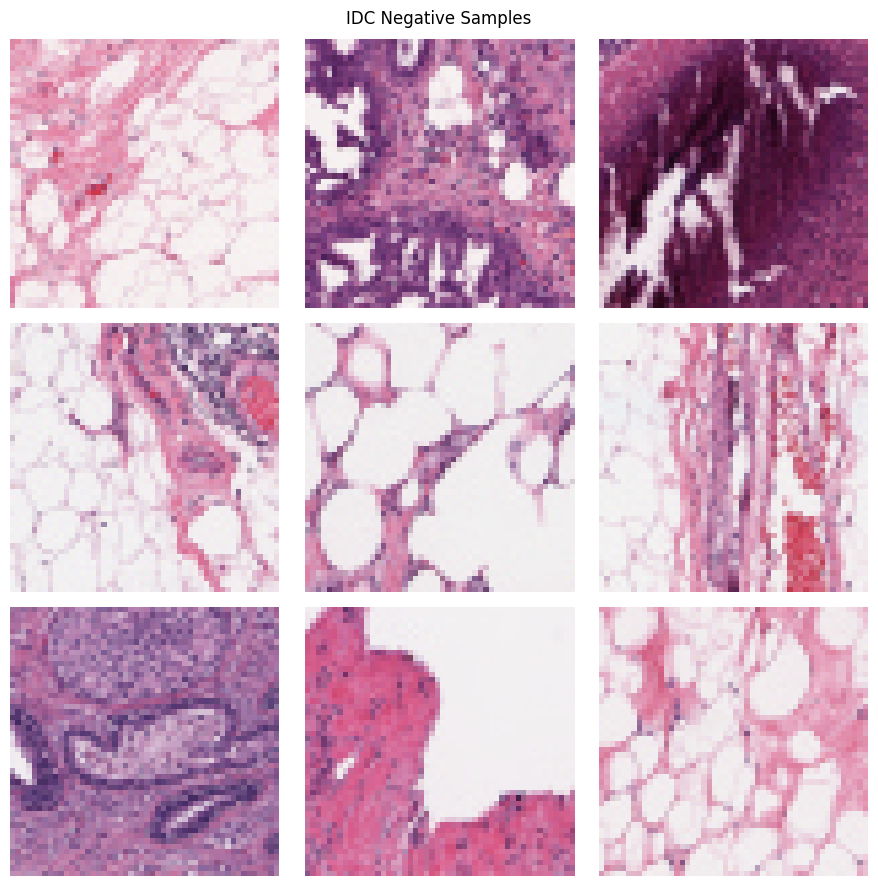

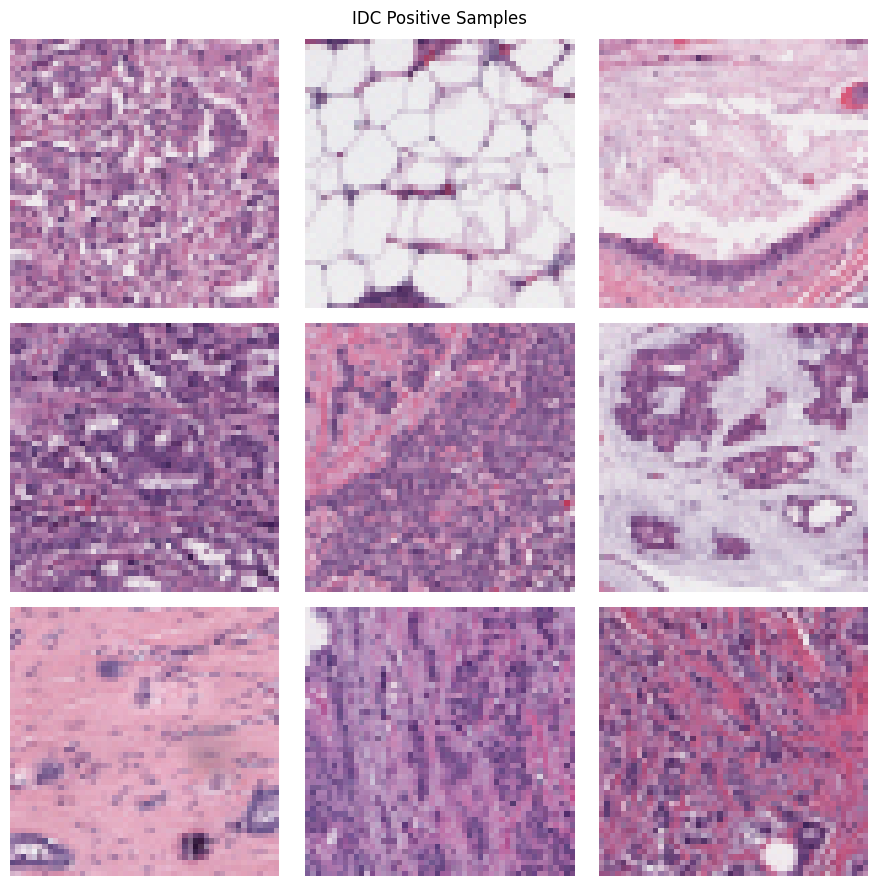

In [23]:
def plot_sample_images(directory, title, num_images=9):
    images = glob.glob(f"{directory}/*.png")
    fig, axs = plt.subplots(3, 3, figsize=(9, 9))
    for i, ax in enumerate(axs.flat[:min(num_images, len(images))]):
        img = plt.imread(images[i])
        ax.imshow(img)
        ax.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_sample_images(idc_negative_directory, "IDC Negative Samples")
plot_sample_images(idc_positive_directory, "IDC Positive Samples")

In [14]:
data_summary = pd.DataFrame({
    "Class": ["IDC Negative", "IDC Positive"],
    "Image Count": [idc_negative_count, idc_positive_count]
})
print(data_summary)

          Class  Image Count
0  IDC Negative       198738
1  IDC Positive        78786


Based on the Kaggle description, the images should all be 50*50 pixels each, but let's ensure that that is accurate.
### 3.1 Checking image size consistency

In [15]:
# Creating a function that plots heights and widths of a picture dataset
# And also returns the values of unique heights and widths

def check_dimensions(image_directory, chosen_height = 50, chosen_width = 50):

    heights = []
    widths = []
    bad_images = []

    image_ds = glob.glob(f'{image_directory}/*.png')
    # Looping on the images to gather height and width data
    for image in image_ds:

        # Load the image and convert it to an array
        sample_image = load_img(image)
        sample_image = img_to_array(sample_image)
        
        # Get the width and height and add to collections
        heights.append(sample_image.shape[0])
        widths.append(sample_image.shape[1])

        # Add all images not equal to 50x50 to a list
        if sample_image.shape != (chosen_height, chosen_width, 3):
            bad_images.append(image)

    # Plotting results on a histogram
    plt.hist(heights, bins = 50, alpha = 0.5, label = "Image Heights")
    plt.hist(widths,  alpha = 0.5, label = "Image Widths")
    plt.xlabel('Image Dimension')
    plt.ylabel('Count')
    plt.legend(loc = 'best')
    plt.show()

    # Check if all heights are the chosen height
    unique_heights = set(heights)

    if unique_heights == {chosen_height}:
        print(f"All heights are {chosen_height}.")
    else:
        print(f"There are heights that are not equal to {chosen_height}.")
        print("Unique heights:", unique_heights)

    
    # Check if all widths are the chosen height
    unique_widths = set(widths)

    if unique_widths == {chosen_height}:
        print(f"All widths are {chosen_height}.")
    else:
        print(f"There are widths that are not equal to {chosen_height}.")
        print("Unique widths:", unique_widths)

    print(f'There are {len(bad_images)} images that are not {chosen_height}x{chosen_width} in the given dataset.')


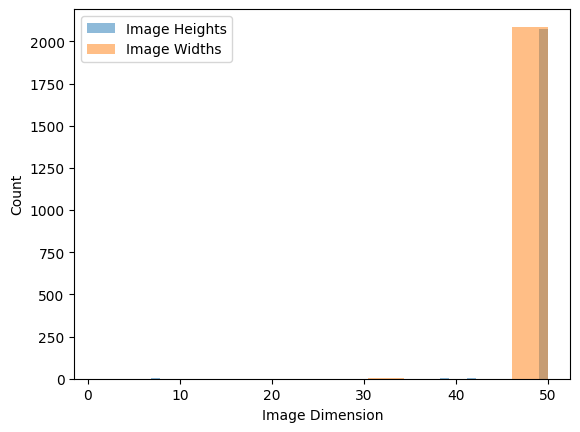

There are heights that are not equal to 50.
Unique heights: {1, 34, 38, 7, 39, 8, 42, 40, 6, 13, 11, 50, 20, 26, 27, 28}
There are widths that are not equal to 50.
Unique widths: {50, 11, 22, 31}
There are 24 images that are not 50x50 in the given dataset.


In [16]:
check_dimensions(sampled_negative_directory)

There are several images in the sample that do not have the correct image size, so the dataset needs to be cleaned.

In [17]:
print(f'Before cleaning, there are {len(positive_images)} IDC+ images and {len(negative_images)} IDC- images.')

Before cleaning, there are 78786 IDC+ images and 198738 IDC- images.


In [18]:
def clean_images(image_directory, chosen_height = 50, chosen_width = 50):

    heights = []
    widths = []
    bad_images = []

    image_ds = glob.glob(f'{image_directory}/*.png')
    # Looping on the images to gather height and width data
    for image in image_ds:

        # Load the image and convert it to an array
        sample_image = load_img(image)
        sample_image = img_to_array(sample_image)
        
        # Get the width and height and add to collections
        heights.append(sample_image.shape[0])
        widths.append(sample_image.shape[1])

        # Add all images not equal to 50x50 to a list
        if sample_image.shape != (chosen_height, chosen_width, 3):
            bad_images.append(image)

    cleaned_images = [x for x in image_ds if x not in bad_images]
    
    return cleaned_images


In [19]:
positive_images = clean_images(idc_positive_directory)
negative_images = clean_images(idc_negative_directory)

In [20]:
idc_negative_count = len(negative_images)
idc_positive_count = len(positive_images)

print(f'After cleaning, there are {idc_positive_count} IDC+ images and {idc_negative_count} IDC- images.')

After cleaning, there are 78768 IDC+ images and 196454 IDC- images.


Of the original 277524 images in the dataset, 2284 images were removed after cleaning.

In [35]:
# Create directories for cleaned data
cleaned_negative_directory = '../cleaned_data/idc_negative/'
cleaned_positive_directory = '../cleaned_data/idc_positive/'

Path(cleaned_negative_directory).mkdir(parents=True, exist_ok=True)
Path(cleaned_positive_directory).mkdir(parents=True, exist_ok=True)

In [36]:
# Function to copy images
def copy_images(dataset, target_dir):
    # images = glob.glob(f'{source_dir}/*.png')
    for image in dataset:
        shutil.copy(image, target_dir)

In [37]:
copy_images(positive_images, cleaned_positive_directory)
copy_images(negative_images, cleaned_negative_directory)

In [40]:
# Updating data summary
data_summary = pd.DataFrame({
    "Class": ["IDC Negative", "IDC Positive"],
    "Image Count": [idc_negative_count, idc_positive_count]
})
print(data_summary)

          Class  Image Count
0  IDC Negative       196454
1  IDC Positive        78768


In [41]:
# Check for class imbalance
total_images = idc_negative_count + idc_positive_count
print(f"Class Distribution:\n{data_summary}")
print(f"IDC Negative: {idc_negative_count / total_images:.2%}, IDC Positive: {idc_positive_count / total_images:.2%}")
if abs(idc_negative_count - idc_positive_count) / total_images > 0.2:
    print("Warning: Potential class imbalance detected.")

Class Distribution:
          Class  Image Count
0  IDC Negative       196454
1  IDC Positive        78768
IDC Negative: 71.38%, IDC Positive: 28.62%


### Prepare Image Dataset

In [42]:
def make_datasets(training_data_path: str, image_dim: int, batch_size: int=32):
    training_dataset = tf.keras.utils.image_dataset_from_directory(
        training_data_path,
        validation_split=0.2,
        subset='training',
        seed=315,
        image_size=(image_dim, image_dim),
        batch_size=batch_size
    )
    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        training_data_path,
        validation_split=0.2,
        subset='validation',
        seed=315,
        image_size=(image_dim, image_dim),
        batch_size=batch_size
    )
    return training_dataset, validation_dataset

image_dim = 128
batch_size = 32
training_dataset, validation_dataset = make_datasets('../cleaned_data/', image_dim, batch_size)

Found 275222 files belonging to 2 classes.
Using 220178 files for training.
Found 275222 files belonging to 2 classes.
Using 55044 files for validation.


In [43]:
training_dataset = training_dataset.take(100)
validation_dataset = validation_dataset.take(50)

### Sample Model

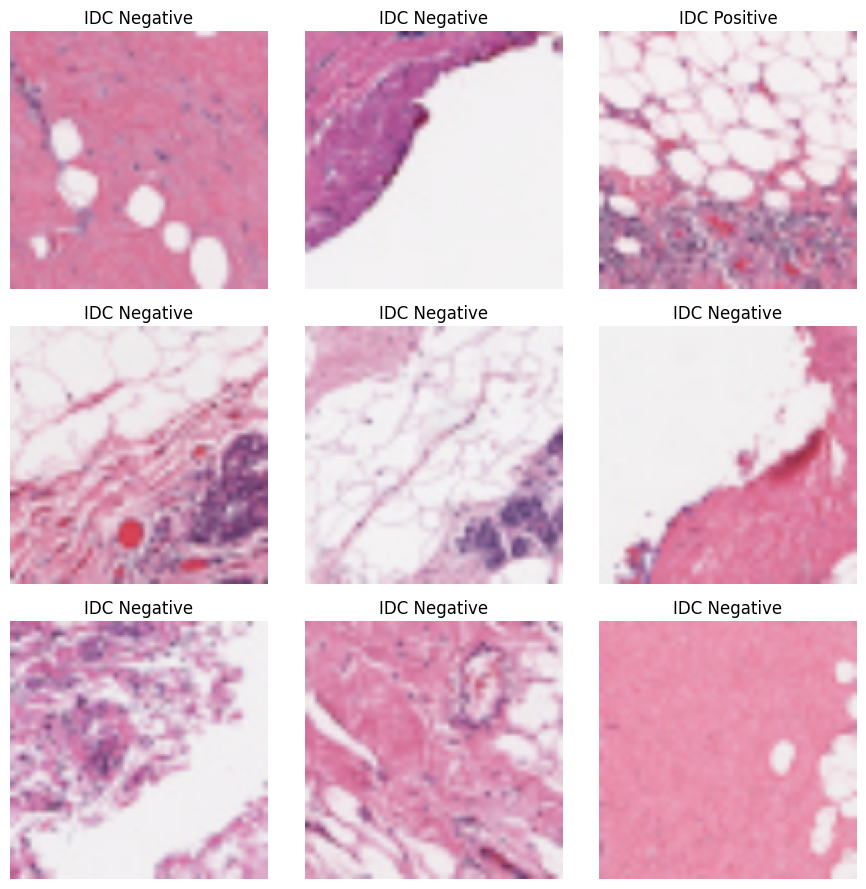

In [44]:
def visualize_images(dataset, class_names):
    images, labels = next(iter(dataset))
    fig, axs = plt.subplots(3, 3, figsize=(9, 9))
    for i, ax in enumerate(axs.flat[:images.shape[0]]):
        ax.imshow(images[i].numpy().astype("uint8"))
        ax.set_title(class_names[int(labels[i])])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

class_names = ['IDC Negative', 'IDC Positive']
visualize_images(training_dataset, class_names)

### define the model

In [45]:
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_dim, image_dim, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compile the model

In [46]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

### Train the model

In [47]:
history = model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=10,
    steps_per_epoch=len(training_dataset),
    validation_steps=len(validation_dataset)
) 

Epoch 1/10


2025-01-25 08:20:17.380553: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65028096 exceeds 10% of free system memory.
2025-01-25 08:20:17.960849: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 30482432 exceeds 10% of free system memory.
2025-01-25 08:20:18.410896: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 30482432 exceeds 10% of free system memory.
2025-01-25 08:20:18.442524: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25719552 exceeds 10% of free system memory.
2025-01-25 08:20:18.629846: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 32514048 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 73s 705ms/step - accuracy: 0.6591 - loss: 22.7948 - val_accuracy: 0.7194 - val_loss: 0.5971
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 80s 692ms/step - accuracy: 0.7152 - loss: 0.6324 - val_accuracy: 0.7287 - val_loss: 0.6346
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 681ms/step - accuracy: 0.7139 - loss: 0.6377 - val_accuracy: 0.7269 - val_loss: 0.6612
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 672ms/step - accuracy: 0.7192 - loss: 0.6545 - val_accuracy: 0.7250 - val_loss: 0.6347
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 681ms/step - accuracy: 0.7177 - loss: 0.6342 - val_accuracy: 0.7231 - val_loss: 0.6403
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 70s 703ms/step - accuracy: 0.7204 - loss: 0.6378 - val_accuracy: 0.7300 - val_loss: 0.6247
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 91s 796ms/step - accuracy: 0.7160 - loss: 0.6276 - val_accuracy: 0.7219 - val_loss: 0.6184
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 68s 660ms/step - accuracy: 0.7221 - loss: 0.6166 - va

### Evaluate the model

In [48]:
loss, accuracy = model.evaluate(validation_dataset)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 207ms/step - accuracy: 0.7156 - loss: 0.6033
Validation Loss: 0.5990, Validation Accuracy: 0.7231


### Training History

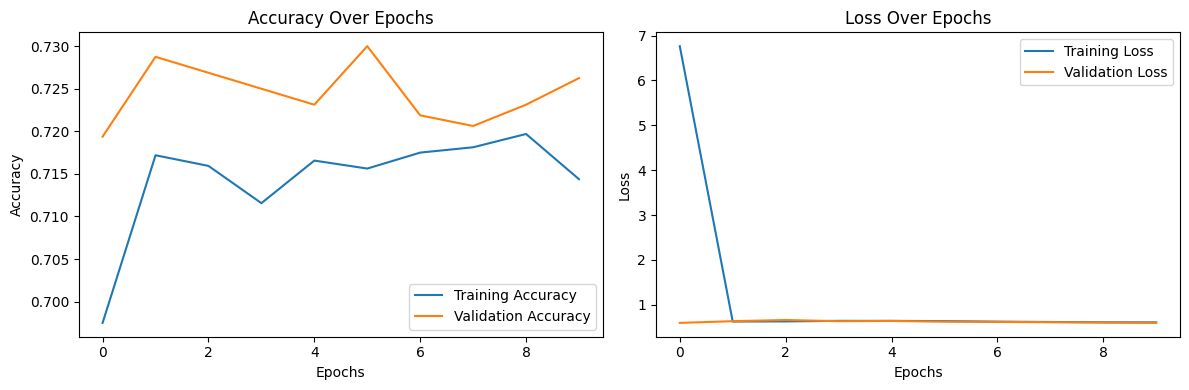

In [49]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Over Epochs')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Over Epochs')

    plt.tight_layout()
    plt.show()

plot_training_history(history)